In [9]:
# 导入包
import numpy as np
import mne
import os
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
%matplotlib qt 

In [11]:
# 数据载入
input_data_path = r"D:\Documents\EEG\standard-EEG\data\静息3min_20250408095252.bdf"  # 修改：脑电数据位置
raw = mne.io.read_raw_bdf(input_data_path, preload=True)  # EEG为读入进来的脑电数据

Extracting EDF parameters from D:\Documents\EEG\standard-EEG\data\静息3min_20250408095252.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 206999  =      0.000 ...   206.999 secs...


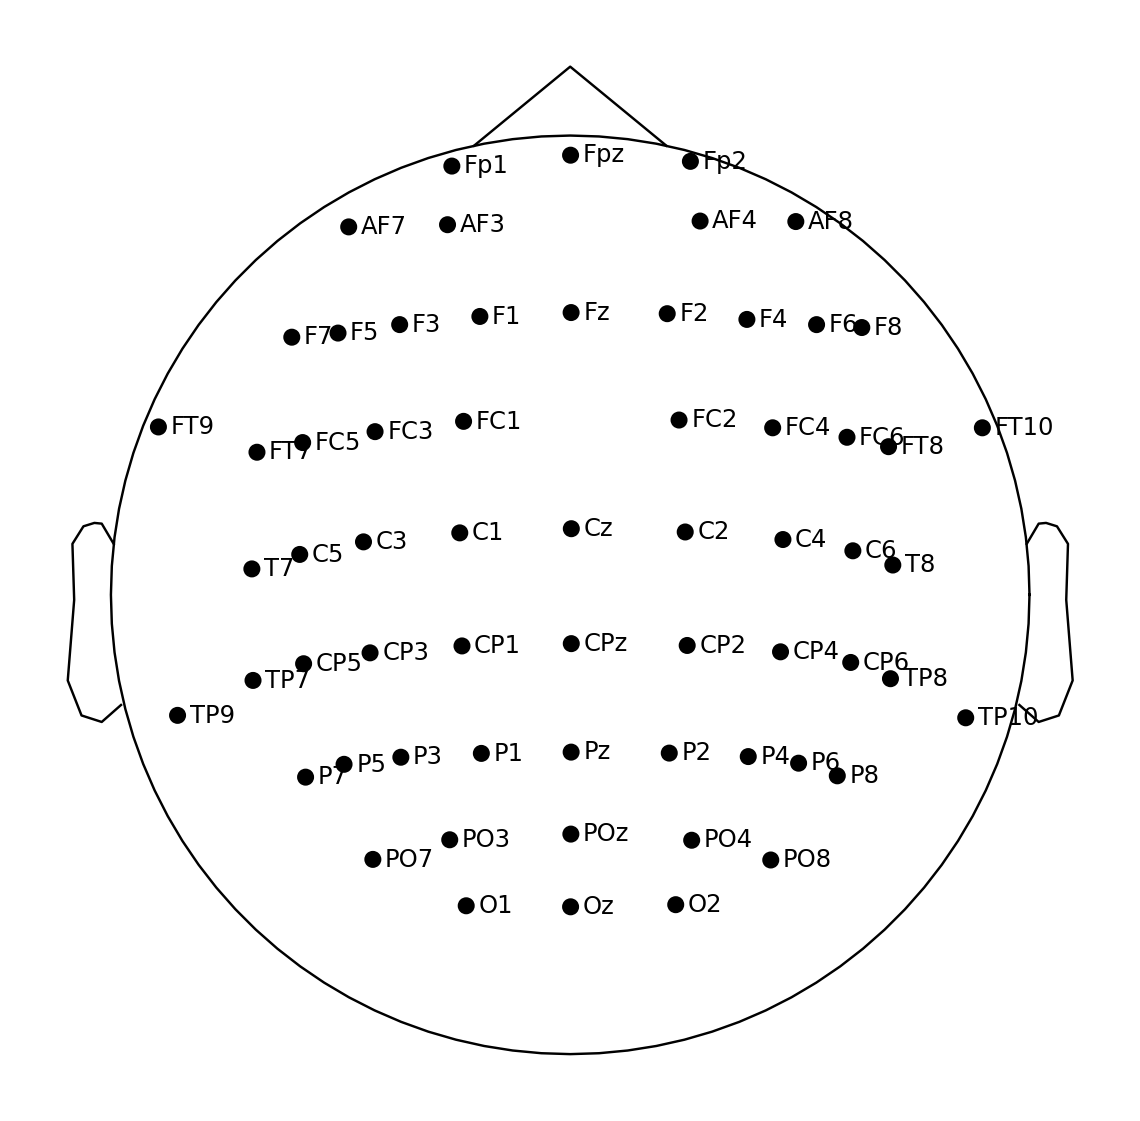

In [12]:
# 对脑电数据的电极位置进行定位
channel_montage = mne.channels.read_custom_montage(r"D:\Documents\EEG\standard-EEG\standard_1005.elc")  # 修改： .elc为电极定位文件（念通智能64导），需根据实际情况修改该文件位置
raw.drop_channels(['I0'])  # 去除眼睛下方的电极
raw.set_montage(channel_montage)  # 将电极位置坐标赋予脑电数据各通道
raw.plot_sensors(kind='topomap', show_names=True)  # 查看电极位置（可注释）

In [14]:
# 查看脑电数据并先删除实验开始前后不稳定的数据
fig = raw.plot(block=True)  # 可视化脑电信号

Channels marked as bad:
none


In [15]:
# 查看脑电数据并先删除实验开始前后不稳定的数据
EEG = raw.copy().crop(tmin=11.314, tmax=raw.times[-1])  # 修改：脑电数据截取时段
fig_after = EEG.plot(block=True)  # 可视化脑电信号

Channels marked as bad:
none


In [16]:
# 滤波
EEG.notch_filter(50)  # 陷波滤波，去除工频干扰50Hz
EEG.filter(l_freq=0.1, h_freq=None)  # 修改：高通滤波，保留大于0.1Hz的波
EEG.filter(l_freq=None, h_freq=100)  # 修改：低通滤波，保留小于100Hz的波

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 s)
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samp

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 133 samples (0.133 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawEDF | 静息3min_20250408095252.bdf, 63 x 195686 (195.7 s), ~94.1 MiB, data loaded>

In [20]:
# 剔除坏导 （Lof算法寻找坏导）
bad_channels = mne.preprocessing.find_bad_channels_lof(EEG, threshold=2)  # 设置threshold，超参数，数值越小越严格

LOF: Detected bad channel(s): []


In [21]:
# 剔除坏导 + 插值坏导
EEG.info['bads'] = bad_channels
print('bad_channels:', EEG.info['bads'])
EEG = EEG.interpolate_bads(reset_bads=True)  # 插值坏导

bad_channels: []
Setting channel interpolation method to {'eeg': 'spline'}.


C:\Users\Fang Yixin\AppData\Local\Temp\ipykernel_15828\2671025940.py:4: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  EEG = EEG.interpolate_bads(reset_bads=True)  # 插值坏导


In [22]:
# 降采样
EEG.resample(sfreq=500)  # 降采样500HZ

Sampling frequency of the instance is already 500.0, returning unmodified.


<RawEDF | 静息3min_20250408095252.bdf, 63 x 97843 (195.7 s), ~47.1 MiB, data loaded>

In [23]:
# #设置重参考
EEG.plot(block=True)
EEG.set_eeg_reference(ref_channels='average')

Channels marked as bad:
none
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | 静息3min_20250408095252.bdf, 63 x 97843 (195.7 s), ~47.1 MiB, data loaded>

In [34]:
# 去伪迹 ICA
ica = ICA(n_components=30,  max_iter='auto')
ica.fit(EEG)
ica.plot_sources(EEG, show=True)
ica.plot_components()

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 2.1s.
Creating RawArray with float64 data, n_channels=30, n_times=97843
    Range : 5657 ... 103499 =     11.314 ...   206.998 secs
Ready.


[<MNEFigure size 1706.25x1692.25 with 20 Axes>,
 <MNEFigure size 1706.25x868 with 10 Axes>]

In [31]:
# ICA 自动寻找肌电
muscle_idx_auto, scores = ica.find_bads_muscle(EEG)
ica.plot_scores(scores, exclude=muscle_idx_auto)  # 输出每一个成分被判断为肌电的分数
print(f"Automatically found muscle artifact ICA components: {muscle_idx_auto}")  # 输出肌电伪迹的成分号

Effective window size : 4.096 (s)
Automatically found muscle artifact ICA components: [2, 3, 4, 7, 8, 9, 12, 16, 17, 18, 19, 28]


In [32]:
ica.plot_properties(raw, picks=[17, 19])  # 结合自行判断+程序判断，查看对应的肌电成分

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 1225x1050 with 6 Axes>, <Figure size 1225x1050 with 6 Axes>]

In [33]:
# ICA 自动寻找眼电
eog_indices, eog_scores = ica.find_bads_eog(EEG, ch_name='Fpz')  # 设置伪眼电通道 ‘FPz’
print(f"Automatically found eye artifact ICA components: {eog_indices}")

Using EOG channel: Fpz
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)
... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 63 PCA components


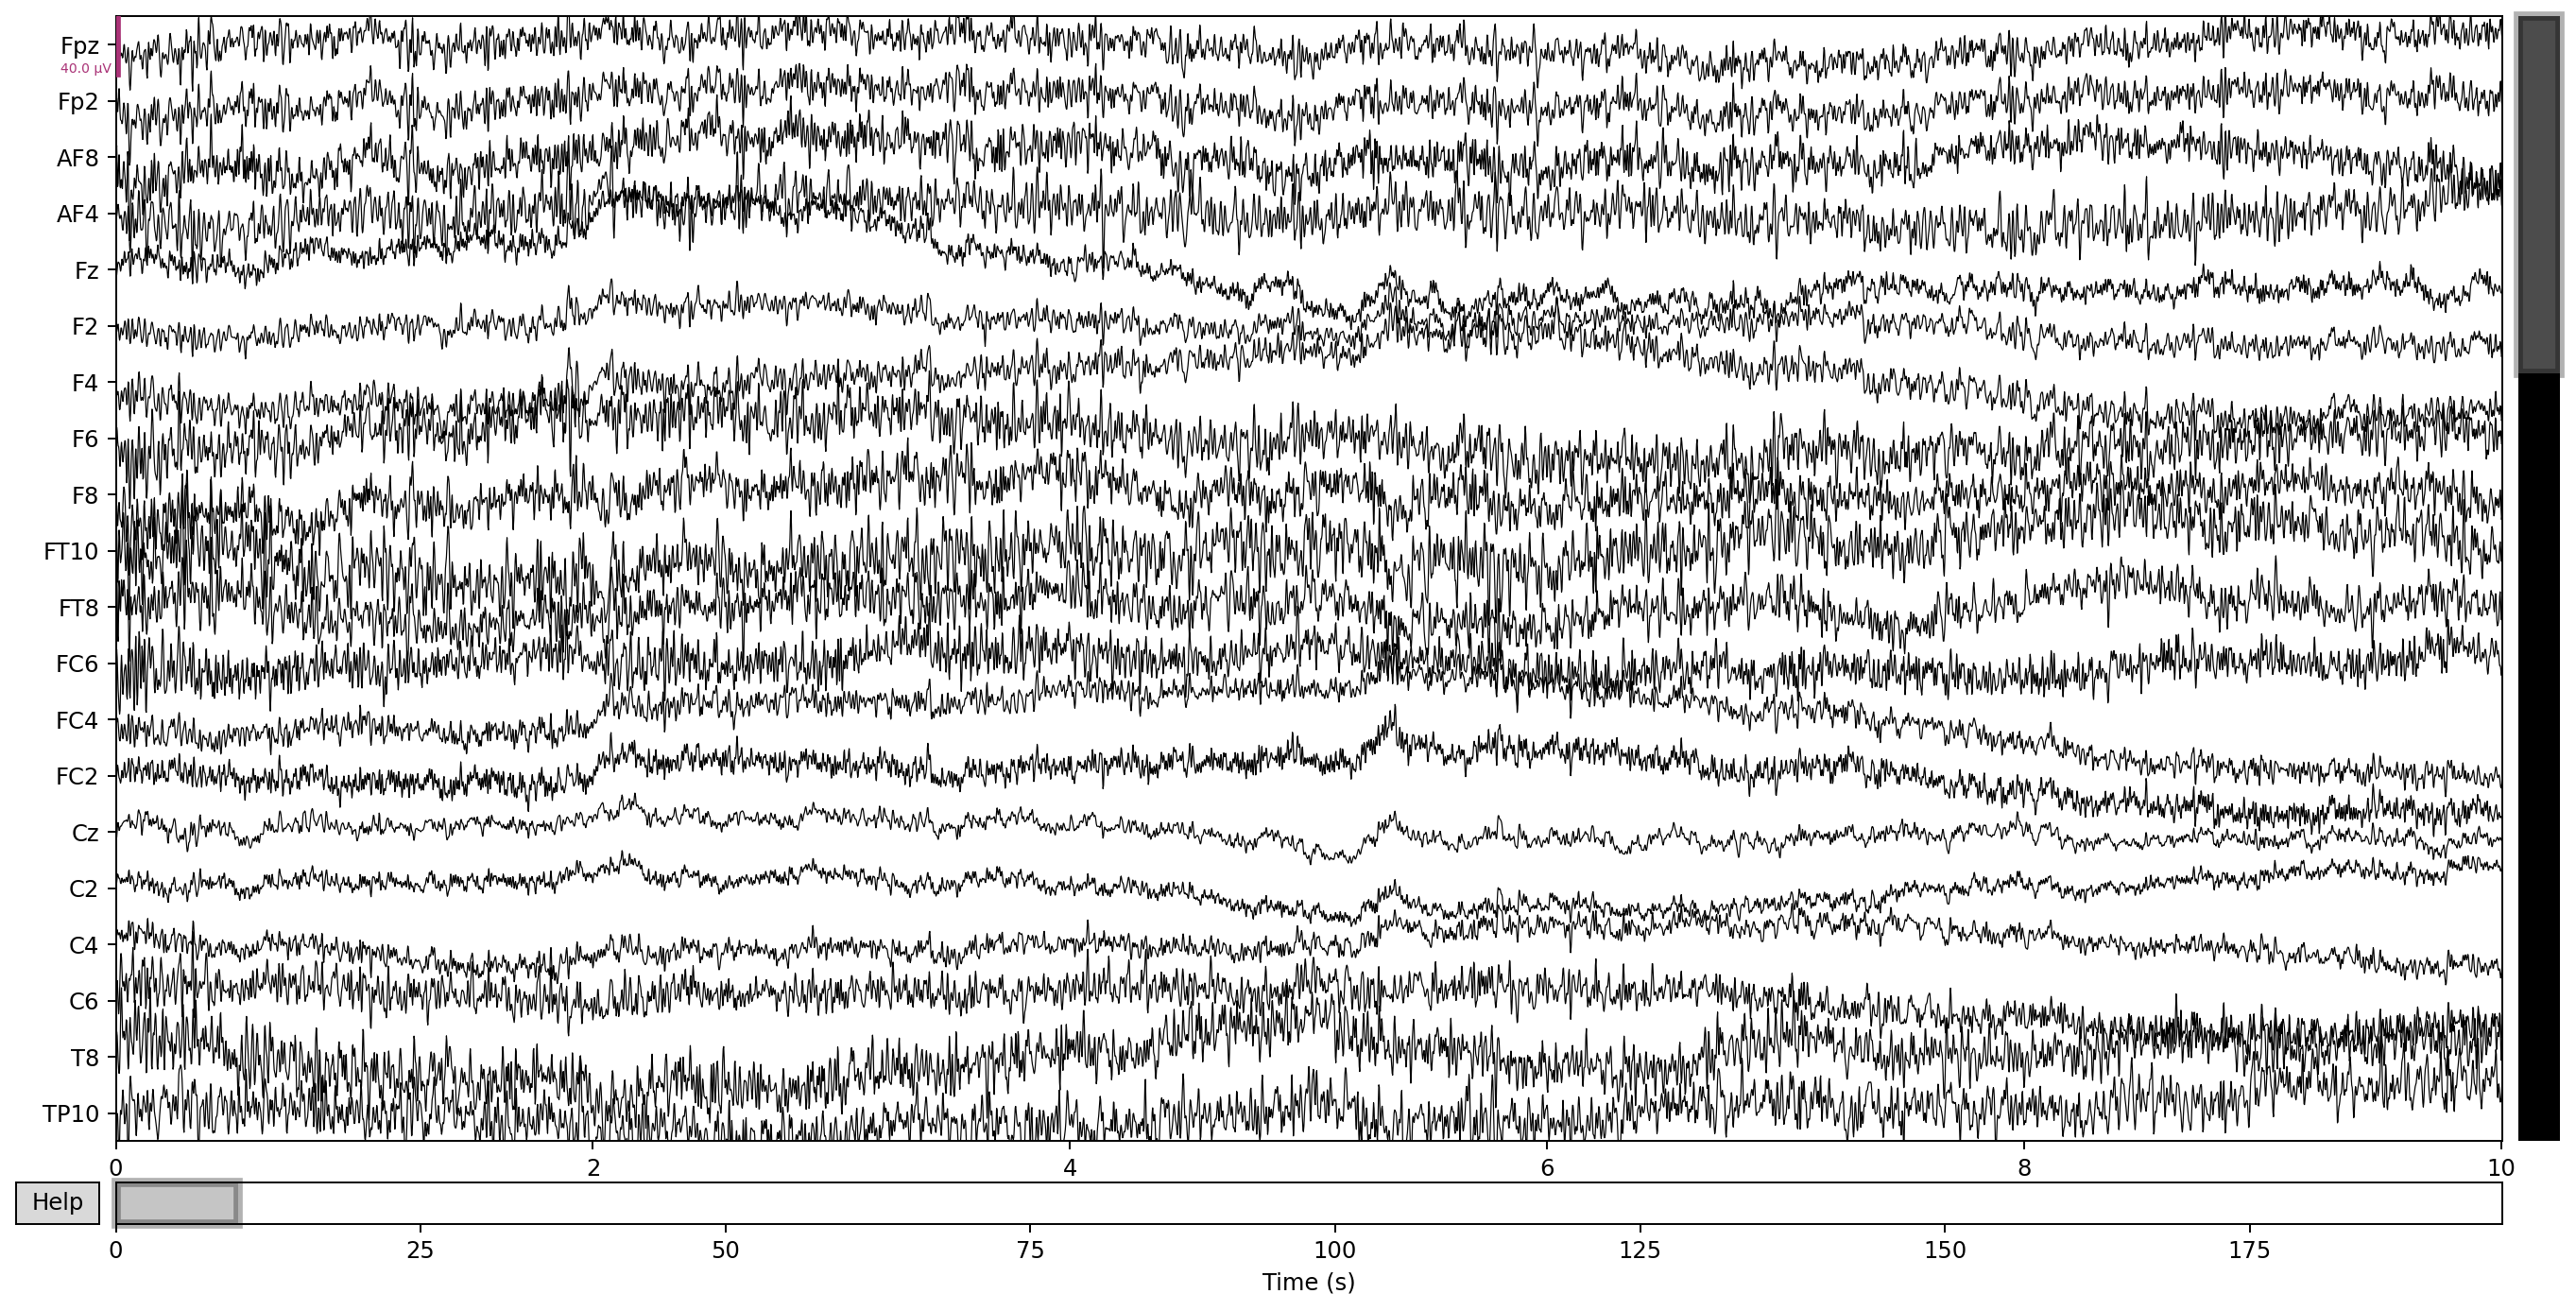

In [35]:
# 剔除肌电、眼电、心电成分
ica.exclude = [1, 6, 17, 19]
ica.apply(EEG)
EEG.plot(show=True)

In [36]:
# 输出预处理后的脑电信号
output_data_path = r"D:\Documents\EEG\standard-EEG\data\preocessed_eeg.fif"
EEG.save(output_data_path)

Writing D:\Documents\EEG\standard-EEG\data\preocessed_eeg.fif
Closing D:\Documents\EEG\standard-EEG\data\preocessed_eeg.fif
[done]


[WindowsPath('D:/Documents/EEG/standard-EEG/data/preocessed_eeg.fif')]